In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#check GPU (optional)
!nvidia-smi

Sun Mar 20 09:12:29 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [23]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import sys

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as tt
import torch.optim as optim
from torchsummary import summary

ROOT_PATH = '/content/drive/MyDrive/QMUL/NN/code/nn_group5'
sys.path.append(ROOT_PATH)
from my_module import functions as myf
from my_module import make_dataset as mds
model_path = '/content/drive/MyDrive/QMUL/NN/code/model_para/'

myf.torch_fix_seed()


In [ ]:
#get dataloader
train_transform = tt.Compose(
    [tt.ToTensor(),
     tt.RandomHorizontalFlip(),
     tt.RandomRotation(10),
     tt.Normalize(0.5, 0.5)])
validation_transform = tt.Compose(
    [tt.ToTensor(),tt.Normalize(0.5, 0.5)])

train_dl = mds.get_dl(
    data='training', 
    bs=64, 
    shuffle=True, 
    transform=train_transform
)
validation_dl = mds.get_dl(
    data='validation', 
    bs=64, 
    shuffle=False, 
    transform=validation_transform
)
test_dl = mds.get_dl(
    data='test', 
    bs=64, 
    shuffle=False, 
    transform=validation_transform
)
dev = "cuda" if torch.cuda.is_available() else "cpu"

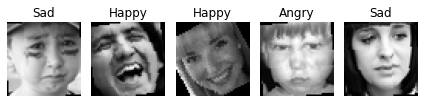

In [ ]:
#check some samples
dict_classes={
    0: 'Angry',
    1: 'Disgust',
    2: 'Fear',
    3: 'Happy',
    4: 'Sad',
    5: 'Surprised',
    6: 'Neutral'
  }
fig, axes = plt.subplots(1, 5, tight_layout=True)
for i in range(5):
    img, label = train_dl.dataset[np.random.randint(0,10000)]
    axes[i].imshow(img.squeeze(), cmap='gray')
    axes[i].axis('off')
    axes[i].set_title(dict_classes[label])


In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ELU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet12(nn.Module):
    def __init__(self):
        super(ResNet12, self).__init__()
        self.conv1 = conv_block(1, 128)
        self.conv2 = conv_block(128, 128, pool=True)
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        self.drop1 = nn.Dropout(0.5)
        
        self.conv3 = conv_block(128, 256)
        self.conv4 = conv_block(256, 256, pool=True)
        self.res2 = nn.Sequential(conv_block(256, 256), conv_block(256, 256))
        self.drop2 = nn.Dropout(0.5)
        
        self.conv5 = conv_block(256, 512)
        self.conv6 = conv_block(512, 512, pool=True)
        self.res3 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        self.drop3 = nn.Dropout(0.5)
        
        self.classifier = nn.Sequential(nn.MaxPool2d(6), 
                                        nn.Flatten(),
                                        nn.Linear(512, 7))

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.drop1(out)
        
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.drop2(out)
        
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out) + out
        out = self.drop3(out)
        
        out = self.classifier(out)
        return out

In [ ]:
model = ResNet12().to(dev)
optimizer = optim.Adam(model.parameters(), weight_decay=1e-4)
epochs = 60

train_acc, val_acc = myf.fit(
    model,
    optimizer,
    epochs,
    train_dl,
    validation_dl,
    print_loss=True
)
torch.save(model.state_dict(), model_path + 'ResNet12.pth')
np.save('/content/drive/MyDrive/QMUL/NN/code/result/ResNet12_train', train_acc)
np.save('/content/drive/MyDrive/QMUL/NN/code/result/ResNet12_val', val_acc)

Epoch 1
loss: 1.950887  [ 6336/28709]
loss: 2.007356  [12736/28709]
loss: 1.791481  [19136/28709]
loss: 1.598697  [25536/28709]
Train accuracy: 26.4% 
Val accuracy  : 30.1%
-------------------------------
Epoch 2
loss: 1.602696  [ 6336/28709]
loss: 1.447631  [12736/28709]
loss: 1.539823  [19136/28709]
loss: 1.519131  [25536/28709]
Train accuracy: 35.9% 
Val accuracy  : 39.6%
-------------------------------
Epoch 3
loss: 1.608651  [ 6336/28709]
loss: 1.422988  [12736/28709]
loss: 1.531124  [19136/28709]
loss: 1.454546  [25536/28709]
Train accuracy: 40.4% 
Val accuracy  : 46.8%
-------------------------------
Epoch 4
loss: 1.701687  [ 6336/28709]
loss: 1.467204  [12736/28709]
loss: 1.333459  [19136/28709]
loss: 1.370058  [25536/28709]
Train accuracy: 43.5% 
Val accuracy  : 48.2%
-------------------------------
Epoch 5
loss: 1.474260  [ 6336/28709]
loss: 1.345200  [12736/28709]
loss: 1.268262  [19136/28709]
loss: 1.534227  [25536/28709]
Train accuracy: 45.6% 
Val accuracy  : 51.8%
-------

In [ ]:
test_acc = myf.test_loop(
    test_dl,
    model,
    nn.CrossEntropyLoss())
print(test_acc)

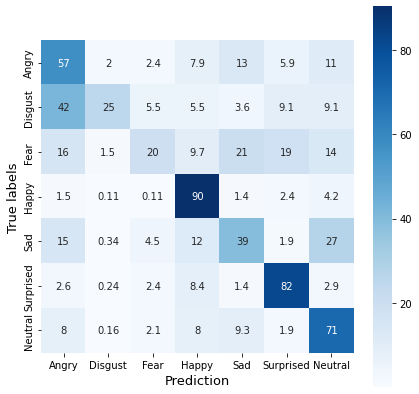

In [ ]:
myf.plot_cfmat(
    model, 
    validation_dl, 
    dict_classes, 
    savefig=True, 
    name='3_ResNet12_cfmat')